In [1]:
import pandas as pd
import seaborn as sns
import unidecode
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
import re
import ast
import numpy as np
import os
import io
import tensorflow as tf
from sklearn.metrics import matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
df_train = pd.read_csv("tweet_train.csv")
df_test = pd.read_csv("tweet_test.csv")
pd.set_option("max_colwidth", 200)
pd.options.display.max_rows = 999

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

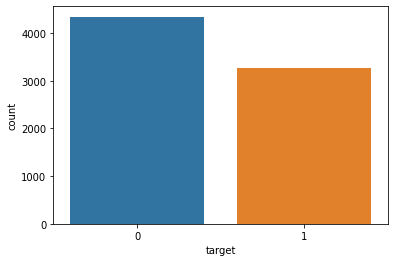

In [6]:
sns.countplot(df_train["target"])
#The training dataset is slightly imbalanced

In [7]:
rng = np.random.default_rng()

In [8]:
#Let's add a target column in the test dataset, it will serve as a random prediction
df_test.loc[:,"target"] = ""
df_test.loc[:,"target"] = rng.integers(2,size=len(df_test["target"]))
df_test.loc[:,"target"] = df_test.loc[:,"target"].astype("int64")
df_test.info(verbose=True)
df_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
 4   target    3263 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 127.6+ KB


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,0
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,0


In [9]:
df_test["target"].value_counts()

1    1670
0    1593
Name: target, dtype: int64

In [10]:
#Let's preprocess the two datasets

nlp = en_core_web_sm.load()

#First on the train set

df_train["text"] = df_train["text"].astype("str")
df_train.loc[:,"text_clean"] = df_train["text"].str.replace('\d+', '') #delete numbers
df_train.loc[:,"text_clean"] = df_train["text_clean"].apply(lambda x: re.sub(r'http\S+', '', x)) #delete http adresses
df_train.loc[:,"text_clean"] = df_train["text_clean"].apply(lambda x: re.sub(r'\S*@\S*\s?', '', x)) #delete email addresses

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df_train.loc[:,"text_clean"] = df_train["text_clean"].apply(deEmojify) #delete emojis

df_train.loc[:,"text_clean"] = df_train["text_clean"].str.replace(r"[^A-Za-z0-9 ]+", " ") #replace punctuation and special characters by spaces
df_train.loc[:,"text_clean"] = df_train["text_clean"].apply(lambda x: x.lower().strip()) #lower case and remove extra spaces
df_train.loc[:,"logs_clean"] = df_train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

#And now the same steps on the test set

df_test["text"] = df_test["text"].astype("str")
df_test.loc[:,"text_clean"] = df_test["text"].str.replace('\d+', '') #delete numbers
df_test.loc[:,"text_clean"] = df_test["text_clean"].apply(lambda x: re.sub(r'http\S+', '', x)) #delete http adresses
df_test.loc[:,"text_clean"] = df_test["text_clean"].apply(lambda x: re.sub(r'\S*@\S*\s?', '', x)) #delete email addresses

df_test.loc[:,"text_clean"] = df_test["text_clean"].apply(deEmojify) #delete emojis

df_test.loc[:,"text_clean"] = df_test["text_clean"].str.replace(r"[^A-Za-z0-9 ]+", " ") #replace punctuation and special characters by spaces
df_test.loc[:,"text_clean"] = df_test["text_clean"].apply(lambda x: x.lower().strip()) #lower case and remove extra spaces
df_test.loc[:,"logs_clean"] = df_test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))


<ipython-input-10-63ac35c62d3f>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.loc[:,"text_clean"] = df_train["text"].str.replace('\d+', '') #delete numbers
<ipython-input-10-63ac35c62d3f>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.loc[:,"text_clean"] = df_train["text_clean"].str.replace(r"[^A-Za-z0-9 ]+", " ") #replace punctuation and special characters by spaces
<ipython-input-10-63ac35c62d3f>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test.loc[:,"text_clean"] = df_test["text"].str.replace('\d+', '') #delete numbers
<ipython-input-10-63ac35c62d3f>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test.loc[:,"text_clean"] = df_test["text_clean"].str.replace(r"[^A-Za-z0-9 ]+", " ") #replace punctuation and special characters by spaces


In [11]:
#We instanciate the tokenizer and set it to keep the 1000 most common words

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)

#We fit the tokenizer on the preprocessed text, it will associate all unique tokens, here 1000, to an integer

tokenizer.fit_on_texts(df_train.text_clean)

#We transform the texts into a sequence of integers

df_train.loc[:,"text_encoded"] = tokenizer.texts_to_sequences(df_train.text_clean)
df_test.loc[:,"text_encoded"] = tokenizer.texts_to_sequences(df_test.text_clean)

#If a text contains only stop words it will be deleted, so we calculate the length to filter those cases

df_train.loc[:,"len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_test.loc[:,"len_text"] = df_test["text_encoded"].apply(lambda x: len(x))

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
#We pad the sequences to the longest one 

max_train = df_train.shape[1]
max_test = df_test.shape[1]
max_len = max([max_train,max_test])

df_pad_train = tf.keras.preprocessing.sequence.pad_sequences(df_train.text_encoded,padding="post",maxlen=max_len)
df_pad_test = tf.keras.preprocessing.sequence.pad_sequences(df_test.text_encoded,padding="post",maxlen=max_len)

target = "target"
n_classes = 2

train_data = tf.data.Dataset.from_tensor_slices((df_pad_train, df_train[target]))
test_data = tf.data.Dataset.from_tensor_slices((df_pad_test,df_test[target]))
y_train = df_train[target]
y_test = df_test[target]

In [13]:
train_data.take(1)

<TakeDataset shapes: ((9,), ()), types: (tf.int32, tf.int64)>

In [14]:
#Let's create and look at one of the batches

train_data = train_data.batch(64)
test_data = test_data.batch(64)

for sample_text,sample_labels in train_data.take(1):
    print(sample_text,sample_labels)

tf.Tensor(
[[ 23   1 829   5  20 246 136  84  39]
 [186  44 215 740   0   0   0   0   0]
 [131  18  40 370 247  58   3 665  23]
 [ 60 247   3  86   0   0   0   0   0]
 [ 20 325  21  29 261  21  68   2 182]
 [371  86 830   3 640 548   4 395  44]
 [207  72 796 277 797 248   5   3   0]
 [  1   7   6  45 104   2  44   3   1]
 [ 73 247  53   3   1 573 831   1 714]
 [ 28  15   1 506   9 239   4 111 254]
 [549  60 619  21   1 262 439  34 620]
 [  6 313  70  54 156   6 313  70 248]
 [248  58 574   6 143 690   0   0   0]
 [207   3 869  35   0   0   0   0   0]
 [218   4 182 416  12   3 122  91 326]
 [ 54   8  30  93   0   0   0   0   0]
 [  6 110   0   0   0   0   0   0   0]
 [314   9   0   0   0   0   0   0   0]
 [ 14 122   9  34 764   0   0   0   0]
 [ 54   2   0   0   0   0   0   0   0]
 [ 20   9   0   0   0   0   0   0   0]
 [950   9 530   0   0   0   0   0   0]
 [110   0   0   0   0   0   0   0   0]
 [ 54   2  89   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 40 149   6 

In [15]:
#Let's set the dimensionality of the representation space

embedding_dim = 16

#The number of words in the vocabulary

vocab_size = tokenizer.num_words

#And let's build the model

model = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[9,],name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
   tf.keras.layers.Flatten() ,
  Dense(n_classes, activation="softmax") # the prediction layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 16)             16016     
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 290       
Total params: 16,306
Trainable params: 16,306
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [17]:
history = model.fit(train_data,validation_data=test_data,epochs=20)

Epoch 1/20
119/119 [==============================] - 1s 2ms/step - loss: 0.6799 - sparse_categorical_accuracy: 0.5815 - val_loss: 0.7066 - val_sparse_categorical_accuracy: 0.4897
Epoch 2/20
119/119 [==============================] - 0s 1ms/step - loss: 0.6154 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.4907
Epoch 3/20
119/119 [==============================] - 0s 1ms/step - loss: 0.5291 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.8256 - val_sparse_categorical_accuracy: 0.4974
Epoch 4/20
119/119 [==============================] - 0s 1ms/step - loss: 0.4654 - sparse_categorical_accuracy: 0.8047 - val_loss: 0.9028 - val_sparse_categorical_accuracy: 0.4977
Epoch 5/20
119/119 [==============================] - 0s 1ms/step - loss: 0.4213 - sparse_categorical_accuracy: 0.8256 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.4968
Epoch 6/20
119/119 [==============================] - 0s 1ms/step - loss: 0.3868 - sparse_categorica

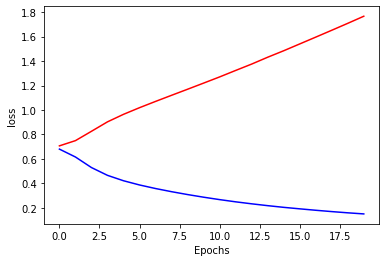

In [18]:
#Visualization of the training process on the loss function
plt.plot(history.history["loss"],color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()


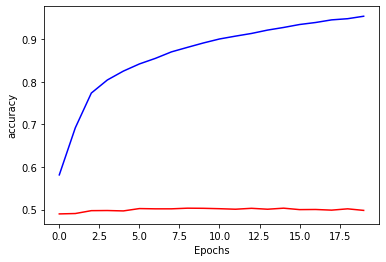

In [19]:
# Visualization of accuracy training 
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [20]:
#Predictions on train set
prob_train = model.predict(train_data)
predictions_train = np.argmax(prob_train,axis=1)

#Predictions on test set
prob_test = model.predict(test_data)
predictions_test = np.argmax(prob_test,axis=1)

<AxesSubplot:>

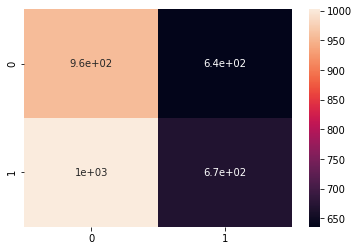

In [21]:
confusion_matrix = tf.math.confusion_matrix(y_test,predictions_test)
sns.heatmap(confusion_matrix,annot=True)

In [22]:
mccf_test = matthews_corrcoef(y_test, predictions_test)
mccf_train = matthews_corrcoef(y_train, predictions_train)

print("MCCF train",mccf_train)
print("MCCF test",mccf_test)

MCCF train 0.919580503256377
MCCF test 0.0007687330978120249
